# How might we use art as input to solid modeling?

## Back at CAD
In a previous post, we looked at some (not so) basics of using solid modeling with `cadquery`, and got a useful widget.

In [1]:
%reload_ext importnb
import pandas as pd
import cadquery as cq
from importnb import Notebook
from IPython.display import SVG
from svgpathtools import real, imag, svg2paths
from lxml import etree as et
from deathbeds import __Revisiting_cadquery_and_ipywidgets_part_1 as CAD

## Load up some art
Inkscape is a powerful UI to master for all kinds of vector image work. It exports a particular dialect of SVG, which is in the XML family.

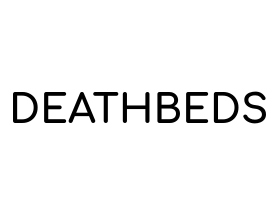

In [2]:
if __name__ == "__main__":
    SVG_PATH = "data/drawing.svg"
    HEIGHT = 0.05
    display(SVG(SVG_PATH))

## Just a little XML
We don't want to spend too much time here, but there's some good metadata in the `<svg>` tag itself, which is the `root` of the XML tree.

In [3]:
if __name__ == "__main__":
    tree = et.parse(SVG_PATH)
    display(tree.getroot().attrib)

{'width': '11in', 'height': '8.5in', 'viewBox': '0 0 279.40001 215.9', 'version': '1.1', 'id': 'svg8', '{http://www.inkscape.org/namespaces/inkscape}version': '0.92.3 (2405546, 2018-03-11)', '{http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd}docname': 'drawing.svg'}

The `viewbox` is the dimensions in... _something_. But it's the something everything else is defined in. There is more work to be done here looking at the `width` and `height` attributes, and what might be able to parse them into `cadquery`-native units.

In [4]:
def get_dimensions_from_xml(tree):
    viewbox = tree.xpath("@viewBox")
    if viewbox:
        return list(map(float, tree.xpath("@viewBox")[0].split(" ")))[2:]
    return list(map(float, [tree.xpath("@width")[0], tree.xpath("@height")[0]]))

Recall the `cadquery.Workplane`, the base API for `cadquery`. We looked at its high-level functions, like `box` and `toSvg` for making, well, boxes and SVGs.

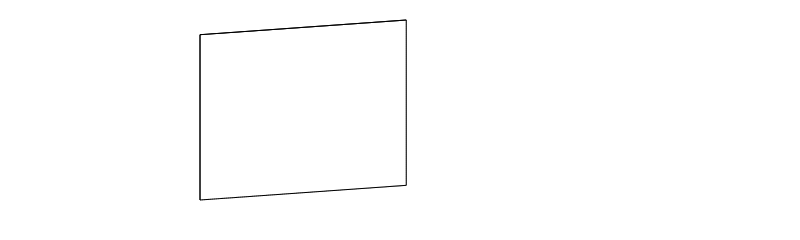

In [5]:
if __name__ == "__main__":
    stage = cq.Workplane("XY").box(*get_dimensions_from_xml(tree) + [HEIGHT])
    display(SVG(stage.toSvg()))

We can have an interactive look at the contents:

In [6]:
with Notebook():
    import __06__Revisiting_cadquery_and_ipywidgets__2 as CAD2
if __name__ == "__main__":
    cad = CAD2.THREECAD()
    display(cad)

THREECAD(children=(Renderer(camera=PerspectiveCamera(position=(30.0, 30.0, 30.0), quaternion=(0.0, 0.0, 0.0, 1…

Nothing much there, yet! Let's put our stage in.

In [7]:
if __name__ == "__main__":
    display(cad)
    cad.part = stage

THREECAD(children=(Renderer(camera=PerspectiveCamera(position=(30.0, 30.0, 30.0), quaternion=(0.0, 0.0, 0.0, 1…

Oooh, that's pretty bad. I can't even tell what I'm looking at. Maybe we can fix the camera angle to be more comfortable.

## Just a Little Math
This is the golden ratio:
$$ \varphi ={\frac {1+{\sqrt {5}}}{2}}=1.6180339887\ldots . $$
It (and its inverse) are useful numbers when laying things out.

In [8]:
ϕ = (1 + pd.np.sqrt(5)) / 2
1 / ϕ

0.6180339887498948

Let's use this to make a jaunty camera angle that scales well to whatever we might throw at it.

In [9]:
def look_at_part(cad):
    bb = cad.part.findSolid().BoundingBox()
    cad.renderer.width = 800
    cad.renderer.height = cad.renderer.width / ϕ 
    cad.camera.aspect = ϕ
    cad.camera.position = [bb.xmax / ϕ, bb.ymax / ϕ, bb.DiagonalLength / ϕ]
    cad.camera.zoom = ϕ / 2 
    cad.camera.lookAt(bb.center.toTuple())
    cad.renderer.render(cad.scene, cad.camera)

In [10]:
if __name__ == "__main__":
    look_at_part(cad)
    display(cad)

THREECAD(children=(Renderer(camera=PerspectiveCamera(aspect=1.618033988749895, position=(86.33935131853025, 66…

## Not better
Right, we actually want to put something on the board. While `cadquery` and `svg` both support complex lines, `svg2paths` makes it easy to do a sampling along the `points` of each path so we can easily control the level of detail.

In [11]:
def get_coordinates_from_svg_paths(svg_file, max_points=100, offset_x=-150.0, offset_y=200.0):
    paths, attributes = svg2paths(svg_file)
    all_points = []
    step = 1 / max_points
    samples = pd.np.arange(0, 1 + step, step)

    for letter in paths:
        for subpath in letter.continuous_subpaths():
            points = list(map(subpath.point, samples))
            all_points.append([[real(p) + offset_x, -imag(p) + offset_y] for p in points])
    return all_points

Then, with each path, we'll want to `extrude` it.

In [12]:
def extrude_path(part, points, depth=1):
    wire = part.moveTo(*points[0])
    for point in points[1:]:
        wire = wire.lineTo(*point)
    wire = wire.close().wire()
    wire.extrude(depth)
    return wire

## Right, so actually building something from a drawing
Let's make a reusable function for extruding some points from a face. In the future, we could look at `cut`.

In [13]:
def make_a_poster_from_an_svg(svg, cad=None, stage=None, callback=None, height=1):
    tree = et.parse(svg)

    if cad is None:
        cad = CAD2.THREECAD()
        display(cad)

    if stage is None:
        dimensions = get_dimensions_from_xml(tree)
        stage = cq.Workplane("XY").box(*dimensions, height)
    
    cad.part = stage

    if callback is None:
        def _callback(path, i):
            cad.part = extrude_path(stage, path, i + 5)

        callback = _callback
    
    paths = get_coordinates_from_svg_paths(svg)
    for i, path in enumerate(paths):
        callback(path, i)
    return cad

In [14]:
if __name__ == "__main__":
    display(cad)
    stage = make_a_poster_from_an_svg(SVG_PATH, cad=cad).part

THREECAD(children=(Renderer(camera=PerspectiveCamera(aspect=1.618033988749895, position=(86.33935131853025, 66…

## Do a little dance
The tesselation gets pretty expensive with fine meshes and lots of geometry actions. But the rendering performance is still snappy enough to support decent animation.

In [15]:
if __name__ == "__main__":
    for i in range(300):
        cad.mesh.rotateY(0.025)
        __import__("time").sleep(1 / 32)

## More?
The resulting geometry is still mutable, so we can pass it right back in to the poster maker.

In [17]:
if __name__ == "__main__":
    def _callback(path, i):
        cad.part = extrude_path(stage, path, (i * i) + 5)
        look_at_part(cad)
        
    make_a_poster_from_an_svg("./data/jupyter-logo.svg", cad=cad, stage=stage, callback=_callback)

## Future Explorations
- [ ] What else does `svgpathtools` hold that would be cool?
- [ ] What about watching a live-updated Inkscape SVG file?
- [ ] What about looking at path colors/gradients, edges, and alternate topologies to get more interesting effects?
- [ ] So can you 3D print from the notebook yet?